Generate synthetic data (without and with dynamical noise)  from the Montbrio model equations using Euler integration. 

In [1]:
import os
import sys
import time
import errno
import time
import timeit


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns

In [2]:
from scipy import stats as spstats
from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
import numba
from numba import jit

In [4]:
import cmdstanpy

In [5]:
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [6]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [7]:
import warnings
warnings.simplefilter("ignore")

In [8]:
print('Running on numpy: v{}'.format(np.version.version))
#print('Running on torch: v{}'.format(torch.__version__))
#print('Running on sbi: v{}'.format(sbi.__version__))

Running on numpy: v1.23.0


In [9]:
cwd = os.getcwd()
cwd

'/home/tng/Documents/montbrio/benchmark_NEW'

In [10]:
Res_dir='Res_syntheticData' 
!mkdir -p $Res_dir
!mkdir -p $Res_dir/data_input_files

In [11]:
SEED = 1

In [12]:
from numba import njit
@njit
def set_seed(value):
    np.random.seed(value)
set_seed(SEED)

# Simulation of Montbrio model


$\dfrac{dr}{dt} = 2rv +\Delta/\pi$

$ \dfrac{dv}{dt} = v^2  -\pi^2 r^2 + Jr+ \eta +I(t) $


In [13]:
def Montbrio_SDEmodel(params, constants, I_input, sigma, dt, ts):
   
    delta, alpha, beta  = params[0], params[1], params[2]
    
    eta=alpha*delta
    J=beta*np.sqrt(delta)

    # simulation from initial point
    v = np.zeros_like(ts)  # fast voltage
    r = np.zeros_like(ts)  # slow voltage

    # fixed parameters
    v_init, r_init=constants[0], constants[1]
    
    dt = float(dt)

    v[0],r[0]= v_init, r_init
        
    for i in range(1, ts.shape[0]):
        dr =(delta/np.pi) +2.*r[i-1]*v[i-1]
        dv = v[i-1]**2  -(np.pi*r[i-1])**2 + J*r[i-1]+ eta +I_input[i-1]
        v[i]=v[i-1] + dt * dv + np.sqrt(dt) * sigma * np.random.randn() 
        r[i]=r[i-1] + dt * dr + np.sqrt(dt) * sigma * np.random.randn() 
        
    return np.concatenate((np.array(v).reshape(-1), np.array(r).reshape(-1),))

In [14]:
Montbrio_SDEmodel_numba = numba.jit(Montbrio_SDEmodel)

## 1. Simulator


In [15]:
t_init = 0.0
t_final = 100.0
dt = 0.001
sigma = 0.0
I0 = 3.
t_on = 30.
t_off = 60.
v0 = -3.0
r0 = 0.5
ts = np.arange(t_init, t_final, dt)
sim_params={'t_init': t_init, 't_final': t_final, 'dt': dt, 'sigma': sigma,
            'I0': I0, 't_on': t_on, 't_off': t_off, 'r0': r0, 'v0': v0}

In [16]:
def Montbrio_SDEmodel_Wrapper(model_params, sim_params, input_type='uniform'):

    params = np.asarray(model_params)
    
    t_init = sim_params['t_init']
    t_final = sim_params['t_final']

    dt = sim_params['dt']
    ts = np.arange(t_init, t_final, dt)
    sigma = sim_params['sigma']
    nIsteps = int((t_final - t_init)/dt)

    I0=sim_params['I0']
    t_on=sim_params['t_on']
    t_off=sim_params['t_off']

    I_input=[]
    if input_type == 'sin' :
        I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 * np.sin(i/318) for i in range(int((t_off - t_on)/dt))] + [0 for i in range(int((t_final - t_off)/dt))]
    else :
        I_input = [0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))]
    
    I_input =np.asarray(I_input)
    
    v0 = sim_params['v0']
    r0 = sim_params['r0']
    
    constants=[v0, r0]
    
    rv = Montbrio_SDEmodel_numba(params, constants, I_input, sigma, dt, ts)

    return rv.reshape(-1), I_input  


### ODE Data

In [17]:
params_label=np.array(['delta', 'alpha', 'beta'])
params_label=np.array(['$\Delta$', '$alpha$', '$beta$'])

In [18]:
delta_true=0.7
eta_true=-4.6
J_true=14.5

alpha_true=eta_true/delta_true
beta_true=J_true/np.sqrt(delta_true)
true_params = np.array([delta_true, alpha_true, beta_true])

In [19]:
data_input_dict= {
    'nt': ts.shape[0], 'ts': ts, 'dt': dt, 't0': t_init, 't_final': t_final,  'I0': I0, 't_on': t_on, 
    't_off': t_off, 'r_init': r0, 'v_init': v0, 
    'rlim': np.r_[0.0, 8.0],'vlim': np.r_[-8.0, 8.0],
    }

In [20]:
y_obs, I_input=Montbrio_SDEmodel_Wrapper(model_params=true_params, 
                                             sim_params=sim_params,
                                             input_type='uniform')

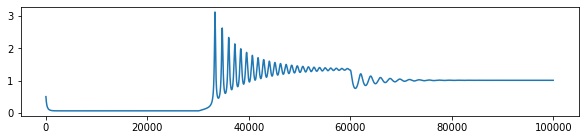

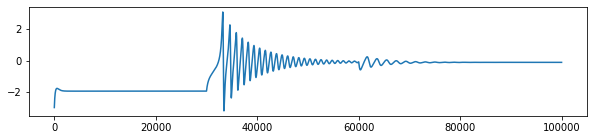

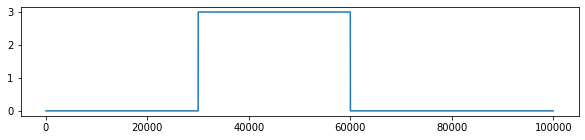

In [21]:
plt.figure(figsize=(10, 2))
N = len(np.arange(t_init, t_final, dt))
plt.plot(y_obs[N:])
plt.figure(figsize=(10, 2))
plt.plot(y_obs[:N])
plt.figure(figsize=(10, 2))
plt.plot(I_input)

### SDE data, for different levels of dynamical noise

In [22]:
sigma_list = [10**(-i) for i in range(0, 7)][::-1]
sigma_list.insert(6, 0.2)
sigma_list.insert(7, 0.5)
sigma_list
sigma_list.insert(0, 0.0)

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]

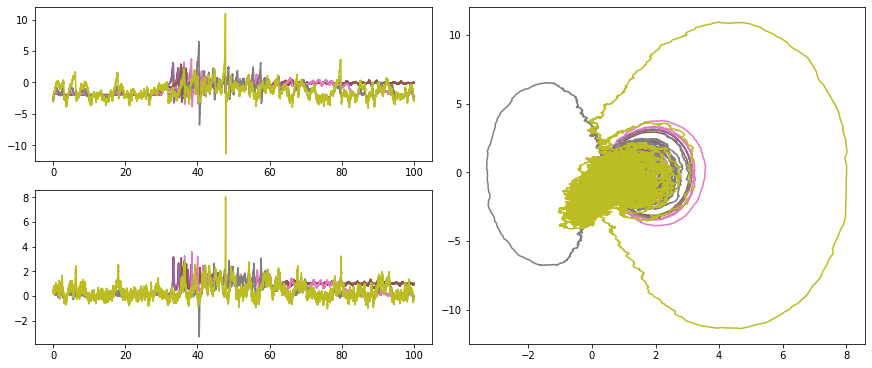

In [23]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              figsize=(12, 5), layout="constrained")

for i, sigma in enumerate(sigma_list) :
    sim_params['sigma'] = sigma
    set_seed(SEED)
    y_obs, I_input=Montbrio_SDEmodel_Wrapper(model_params=true_params, 
                                             sim_params=sim_params,
                                             input_type='uniform')
    vs=y_obs[0:int(y_obs.shape[0]/2)]
    rs=y_obs[int(y_obs.shape[0]/2): int(y_obs.shape[0])]

    axd['upper left'].plot(ts, vs)
    axd['lower left'].plot(ts, rs)
    axd['right'].plot(rs, vs)
    
    data_input_filename=str('data_input_mpr_sd'+ '_sigma='+str(sigma))
    i_dict = {'vs': vs, 'rs': rs, 'delta_true': delta_true, 'eta_true': eta_true, 'J_true': J_true,
             'alpha_true': eta_true/delta_true, 'beta_true': J_true/np.sqrt(delta_true),
             'sigma': sigma, 'I_input': I_input}
    simul_i_dict = {**data_input_dict, **i_dict}
    
    nd=[]
    npz = {'nd': nd}
    npz.update(simul_i_dict)
    np.savez(cwd+'/'+Res_dir+'/data_input_files/'+data_input_filename+'.R.npz', **npz)
    np.savez(cwd+'/'+Res_dir+'/data_input_files/'+data_input_filename+'.npz', **npz)
    cmdstanpy.write_stan_json(cwd+'/'+Res_dir+'/data_input_files/'+data_input_filename+'.json',
                              simul_i_dict)

### SDE data, with sigma = 0.1

In [24]:
data_iput_filename=str('data_input_mpr_sd' + '_sigma=0.1')
data_iput_path = cwd+'/Res_syntheticData/data_input_files/'+ str(data_iput_filename)+ '.R.npz'

In [25]:
data_input = dict(load(data_iput_path))

In [26]:
v_obs, r_obs = data_input['vs'], data_input['rs']

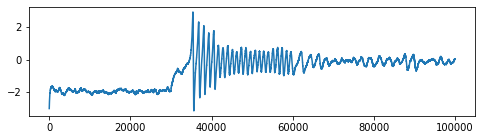

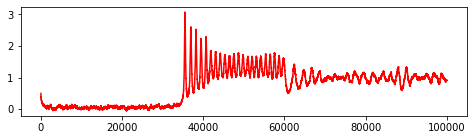

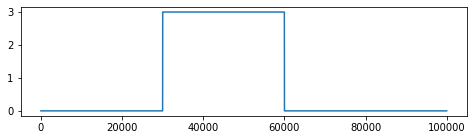

In [27]:
plt.figure(figsize=(8, 2))
plt.plot(v_obs)
plt.figure(figsize=(8, 2))
plt.plot(r_obs, 'r')
plt.figure(figsize=(8, 2))
plt.plot([0 for i in range(int((t_on - t_init)/dt))]+ [I0 for i in range(int((t_off - t_on)/dt))]+ [0 for i in range(int((t_final - t_off)/dt))])